<a href="https://colab.research.google.com/github/coder-zmz/DM-Final/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# 文本特征提取

In [49]:
import warnings
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore')

# 定义一个用于文本预处理的类，继承自 CountVectorizer 的 tokenizer 参数
class LemmaTokenizer:
    """
    用于文本预处理的类，进行词形还原和简单的过滤。
    """
    def __init__(self):
        # 初始化 WordNetLemmatizer 对象，用于词形还原
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        words = []  # 初始化一个空列表，用于存储预处理后的单词
        for t in word_tokenize(doc):  # 使用 word_tokenize 对文本进行分词
            # 过滤掉长度小于 3、包含撇号或波浪号的单词
            if len(t) < 3 or "'" in t or "~" in t:
                continue
            # 对剩余的单词进行词形还原，并将结果添加到 words 列表中
            words.append(self.wnl.lemmatize(t))
        return words  # 返回预处理后的单词列表

# CountVectorizer 参数
params_count = {
    'analyzer': 'word',     # 取值'word'-分词结果为词级、'char'-字符级(结果会出现he is，空格在中间的情况)、'char_wb'-字符级(以单词为边界)，默认值为'word'
    'binary': False,        # boolean类型，设置为True，则所有非零计数都设置为1.（即，tf的值只有0和1，表示出现和不出现）
    'decode_error': 'strict',
    'dtype': np.float64,    # 输出矩阵的数值类型
    'encoding': 'utf-8',
    'input': 'content',     # 取值filename，文本内容所在的文件名；file，序列项必须有一个'read'方法，被调用来获取内存中的字节；content，直接输入文本字符串
    'lowercase': True,      # boolean类型，计算之前是否将所有字符转换为小写。
    'max_df': 0.8,          # 词汇表中忽略文档频率高于该值的词；取值在[0,1]之间的小数时表示文档频率的阈值，取值为整数时(>1)表示文档频数的阈值；如果设置了vocabulary，则忽略此参数。
    'min_df': 0.01,            # 词汇表中忽略文档频率低于该值的词；取值在[0,1]之间的小数时表示文档频率的阈值，取值为整数时(>1)表示文档频数的阈值；如果设置了vocabulary，则忽略此参数。
    'max_features': None,   # int或None(默认值).设置int值时建立一个词汇表，仅用词频排序的前max_features个词创建语料库；如果设置了vocabulary，则忽略此参数。
    'ngram_range': (1, 2),  # 要提取的n-grams中n值范围的下限和上限，min_n <= n <= max_n。
    'preprocessor': None,   # 覆盖预处理（字符串转换）阶段，同时保留标记化和 n-gram 生成步骤。仅适用于analyzer不可调用的情况。
    'stop_words': 'english',    # 仅适用于analyzer='word'。取值english，使用内置的英语停用词表；list，自行设置停停用词列表；默认值None，不会处理停用词
    'strip_accents': None,
    'token_pattern': '(?u)\\b\\w\\w+\\b',   # 分词方式、正则表达式，默认筛选长度>=2的字母和数字混合字符（标点符号被当作分隔符）。仅在analyzer='word'时使用。
    'tokenizer': LemmaTokenizer(),      # 覆盖字符串标记化步骤，同时保留预处理和 n-gram 生成步骤。仅适用于analyzer='word'
    'vocabulary': None,     # 自行设置词汇表（可设置字典），如果没有给出，则从输入文件/文本中确定词汇表
}
# tfidf 参数
params_tfidf = {
    'norm': 'l2',           # 输出结果是否标准化/归一化。l2：向量元素的平方和为1，当应用l2范数时，两个向量之间的余弦相似度是它们的点积；l1：向量元素的绝对值之和为1
    'smooth_idf': True,     # 在文档频率上加1来平滑 idf ，避免分母为0
    'sublinear_tf': True,  # 应用次线性 tf 缩放，即将 tf 替换为 1 + log(tf)
    'use_idf': True,        # 是否计算idf，布尔值，False时idf=1。
}

def text_embedding(data):
    """
    将输入的文本数据转换为文本嵌入向量，使用词袋模型和 TF-IDF 技术。

    Args:
        data: 输入文本数据，可以是字符串列表或其他可迭代对象。

    Returns:
        文本嵌入向量，以 NumPy 数组的形式返回。
    """

    # 创建 CountVectorizer 对象，并使用 params_count 中的参数进行配置
    cv = CountVectorizer(**params_count)
    # 使用 CountVectorizer 拟合数据并转换文本
    x_cv = cv.fit_transform(data)

    # 获取特征词列表
    vocabulary = cv.get_feature_names_out()
    # 打印特征词列表
    #print(f"特征词列表：\n{vocabulary}")
    # 打印词频矩阵
    #print(f"词频矩阵：\n{x_cv.toarray()}")


    # 创建 TfidfTransformer 对象，并使用 params_tfidf 中的参数进行配置
    tt = TfidfTransformer(**params_tfidf)
    # 使用 TfidfTransformer 拟合数据并转换文本
    x_tfidf = tt.fit_transform(x_cv.toarray())
    # 打印 TF-IDF 矩阵
    #print(f"TF-IDF 矩阵：\n{x_tfidf.toarray()}")

    # 返回 TF-IDF 矩阵作为文本嵌入向量
    return x_tfidf.toarray()

In [9]:
# 测试
train_data = ["Chinese Beijing Chinese ",
        "Chinese Chinese Shanghai",
        "Chinese Macao",
        "Tokyo Japan Chinese"]
print(text_embedding(train_data))

[[0.57735027 0.57735027 0.57735027 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.57735027 0.         0.57735027
  0.         0.         0.         0.57735027 0.         0.        ]
 [0.         0.         0.         0.         0.70710678 0.
  0.         0.         0.70710678 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.5        0.         0.         0.5        0.5       ]]


# 读取数据

In [71]:
import torch
from torch_geometric.data import Data

def read_data(dataset_name):
    """
    读取cora数据集，并将其转换为torch_geometric的数据格式。

    Args:
        dataset_name: 数据集名称，例如"cora"。

    Returns:
        一个torch_geometric的Data对象，包含节点特征、边索引和节点标签。
    """
    # 定义文件路径
    base_path = "/content/drive/MyDrive/DM-Final/data_2/"
    edge_path = base_path + dataset_name + ".edge"
    label_path = base_path + dataset_name + ".label"
    label_name_path = base_path + dataset_name + ".label_name"
    text_path = base_path + dataset_name + ".text"

    # 读取标签对应名称
    label_name_dict = {}
    with open(label_name_path, 'r') as f:
        for line in f:
            label, name = line.strip().split(" ", 1)
            label_name_dict[int(label)] = name

    # 读取边信息
    edges = []
    with open(edge_path, 'r') as f:
        for line in f:
            source, target = map(int, line.strip().split())
            edges.append((source, target))

    # 将边信息转换为PyTorch张量
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # 读取节点标签
    labels = {}
    with open(label_path, 'r') as f:
        for line in f:
            node_id, label = map(int, line.strip().split())
            labels[node_id] = label

    # 将节点标签转换为PyTorch张量
    y = torch.tensor([labels[i] for i in range(len(labels))], dtype=torch.long)

    # 读取文本特征
    node_texts = {}
    with open(text_path, "r") as f:
        for line in f:
            node_id, text = line.strip().split(" ", 1)  # 以第一个空格分割
            node_texts[int(node_id)] = text

    # 获取节点特征
    node_features = text_embedding(list(node_texts.values()))
    x = torch.tensor(node_features, dtype=torch.float32)

    # 创建Data对象
    data = Data(x=x, edge_index=edge_index, y=y)

    return data, label_name_dict

In [72]:
# 读取cora数据集
cora_data = read_data("cora")
data = cora_data[0]

In [52]:
# 验证数据集
data.validate()

# 检查 data.x 的最小值和最大值
min_val = torch.min(data.x)
max_val = torch.max(data.x)

print(f"Minimum value: {min_val}")
print(f"Maximum value: {max_val}")

print(f"data.x.shape: {data.x.shape}")
print(f"data.edge_index.shape: {data.edge_index.shape}")
print(f"data.y.shape: {data.y.shape}")

Minimum value: 0.0
Maximum value: 1.0
data.x.shape: torch.Size([2708, 1150])
data.edge_index.shape: torch.Size([2, 10858])
data.y.shape: torch.Size([2708])


# 数据预处理

## 降维

In [76]:
from sklearn.decomposition import PCA

# 假设 cora_data.x 是你的特征矩阵
# 创建 PCA 对象，指定降维后的维度
pca = PCA(n_components=500)  # 例如降到 500 维

# 对特征矩阵进行降维
reduced_features = pca.fit_transform(data.x)

# 将降维后的特征转换为 PyTorch 张量
data.x = torch.tensor(reduced_features, dtype=torch.float32)

# 检查降维后的数据
data.x.shape

torch.Size([2708, 500])

## 划分数据集

In [77]:
num_nodes = data.num_nodes
num_train = int(0.6 * num_nodes)  # 60% 用于训练
num_val = int(0.2 * num_nodes)    # 20% 用于验证

# 随机选择训练集节点
train_idx = torch.randperm(num_nodes)[:num_train]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True

# 随机选择验证集节点
val_idx = torch.randperm(num_nodes)[num_train:num_train + num_val]
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[val_idx] = True

# 其余节点作为测试集
test_mask = ~(train_mask | val_mask)

# 将掩码添加到 data 对象
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [78]:
print(data.train_mask)
print(data.val_mask)
print(data.test_mask)

tensor([False, False,  True,  ..., False,  True, False])
tensor([False, False, False,  ...,  True, False,  True])
tensor([ True,  True, False,  ..., False, False, False])


# 使用官方数据集训练模型

## 数据集获取

In [66]:
# 数据集相关信息
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="tmp", name = "Cora", transform=NormalizeFeatures())

print()
print(f"datasets:{dataset}")
print(f"num of graphs:{len(dataset)}")
print(f"num of features:{dataset.num_features}")
print(f"num of classes: {dataset.num_classes}")

data = dataset[0]

print(data)
print(f"num of nodes: {data.num_nodes}")
print(f"num of node_features: {data.num_node_features}")
print(f"num of edges: {data.num_edges}")

print(f"num of training node: {data.train_mask.sum()}")
print(f"training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")


datasets:Cora()
num of graphs:1
num of features:1433
num of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
num of nodes: 2708
num of node_features: 1433
num of edges: 10556
num of training node: 140
training node label rate: 0.05


In [70]:
print(dir(dataset))

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_data', '_data_list', '_download', '_indices', '_infer_num_classes', '_is_protocol', '_process', 'collate', 'copy', 'cpu', 'cuda', 'data', 'download', 'force_reload', 'geom_gcn_url', 'get', 'get_summary', 'has_download', 'has_process', 'index_select', 'indices', 'len', 'load', 'log', 'name', 'num_classes', 'num_edge_features', 'num_features', 'num_node_features', 'pre_filter', 'pre_transform', 'print_summary', 'process', 'processed_dir', 'processed_file_names', 'processed_paths', 'raw_dir', 'raw_

## GCN

In [81]:
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels) -> None:
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, data.num_node_features)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        # 对输入的节点特征 x 进行 Dropout 操作，以减少过拟合风险。
        # p=0.5 表示丢弃概率为0.5，即有50%的概率将输入置零。
        h = F.dropout(h,p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return h

model = GCN(hidden_channels=16)
print(model)
# 模型训练
model = GCN(hidden_channels=16)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr = 0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()  # 梯度清理
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward() # 误差反向传播
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

epoch = 201
for epoch in range(1, epoch):
    loss = train()
    test_acc = test()
    if epoch % 10 == 0:
        print(f"epoch:{epoch}  loss:{loss}  test_acc:{test_acc}")


GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 500)
)
epoch:10  loss:5.83530855178833  test_acc:0.5011574074074074
epoch:20  loss:4.82350492477417  test_acc:0.5486111111111112
epoch:30  loss:3.19067120552063  test_acc:0.5300925925925926
epoch:40  loss:2.1115095615386963  test_acc:0.4166666666666667
epoch:50  loss:1.7661548852920532  test_acc:0.3136574074074074
epoch:60  loss:1.5712745189666748  test_acc:0.3784722222222222
epoch:70  loss:1.3887962102890015  test_acc:0.6435185185185185
epoch:80  loss:1.1825562715530396  test_acc:0.7465277777777778
epoch:90  loss:0.9871675968170166  test_acc:0.7893518518518519
epoch:100  loss:0.8176575303077698  test_acc:0.8414351851851852
epoch:110  loss:0.6870840787887573  test_acc:0.8634259259259259
epoch:120  loss:0.6220828890800476  test_acc:0.8738425925925926
epoch:130  loss:0.5435685515403748  test_acc:0.8761574074074074
epoch:140  loss:0.5227717161178589  test_acc:0.8784722222222222
epoch:150  loss:0.49155789613723755  test_acc:0.88194444

## GAT

In [ ]:
# prompt: 使用citeseer数据集训练gat模型

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv
import torch
import torch.nn.functional as F

# GAT 模型
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=8, dropout=0.6)
        # heads参数控制多头注意力机制的头数。
        # dropout参数控制dropout的比例，用于防止过拟合。
        self.conv2 = GATConv(hidden_channels * 8, dataset.num_classes, heads=1, concat=False, dropout=0.6)
        # concat参数控制是否将多头注意力的结果拼接起来，这里设置为False，表示取平均。


    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8)
print(model)

# 模型训练
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    return acc

epochs = 200
for epoch in range(1, epochs + 1):
    loss = train()
    test_acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

GAT(
  (conv1): GATConv(3703, 8, heads=8)
  (conv2): GATConv(64, 6, heads=1)
)
Epoch: 010, Loss: 1.7560, Train Acc: 0.5320
Epoch: 020, Loss: 1.6571, Train Acc: 0.5790
Epoch: 030, Loss: 1.5536, Train Acc: 0.6950
Epoch: 040, Loss: 1.4788, Train Acc: 0.7070
Epoch: 050, Loss: 1.3746, Train Acc: 0.6960
Epoch: 060, Loss: 1.3372, Train Acc: 0.6880
Epoch: 070, Loss: 1.2614, Train Acc: 0.7110
Epoch: 080, Loss: 1.1039, Train Acc: 0.7010
Epoch: 090, Loss: 1.0973, Train Acc: 0.6830
Epoch: 100, Loss: 1.1166, Train Acc: 0.6960
Epoch: 110, Loss: 0.9640, Train Acc: 0.7020
Epoch: 120, Loss: 0.9087, Train Acc: 0.6900
Epoch: 130, Loss: 0.9660, Train Acc: 0.7140
Epoch: 140, Loss: 1.0028, Train Acc: 0.6940
Epoch: 150, Loss: 0.8540, Train Acc: 0.7140
Epoch: 160, Loss: 0.9826, Train Acc: 0.6850
Epoch: 170, Loss: 0.9480, Train Acc: 0.7090
Epoch: 180, Loss: 0.8092, Train Acc: 0.7100
Epoch: 190, Loss: 0.6747, Train Acc: 0.7060
Epoch: 200, Loss: 0.7879, Train Acc: 0.7100


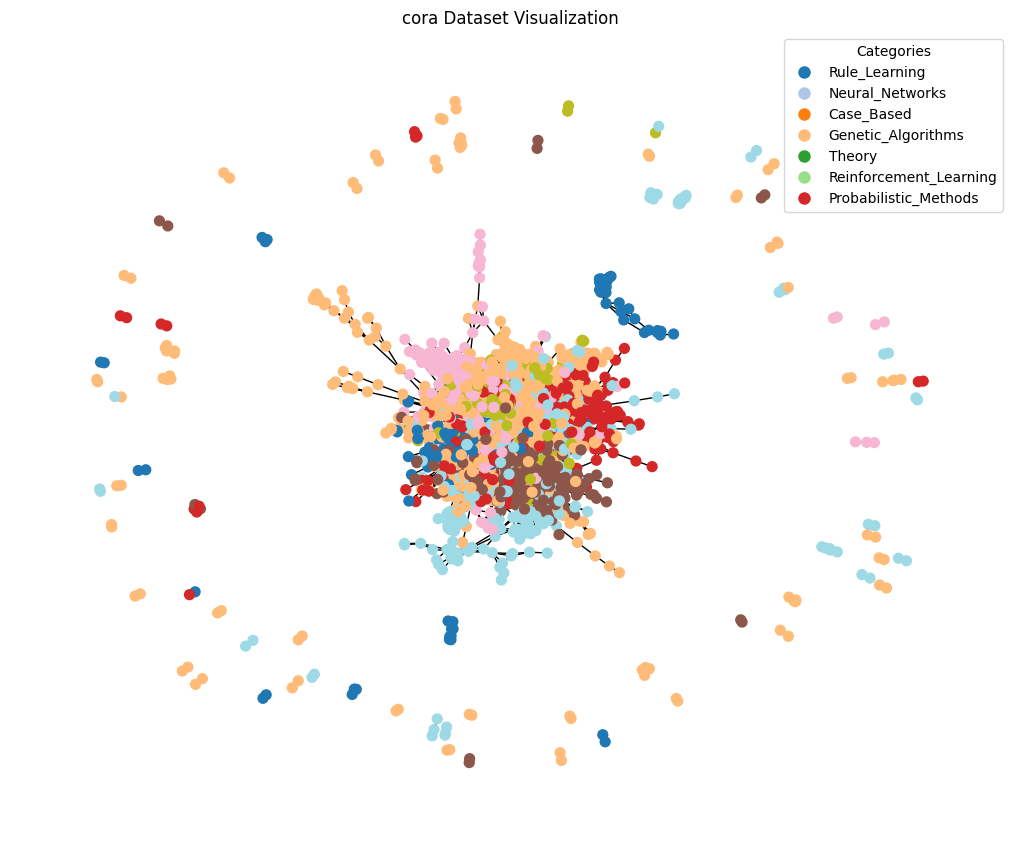

In [ ]:
# prompt: /content/drive/MyDrive/DM-Final/data_2路径下存储有cora数据集，请针对此数据集进行可视化工作
# 数据集分为四个文件存储，其后缀分别为.edge、.label、.label_name、.text
# .edge 文件：
# 每一行包含两个以空格隔开的数字，代表图中的一个边。
# 第一个数字是源节点（即引用论文）的ID，第二个数字是目标节点（即被引用论文）的ID。
# 例如：1552 642 表示节点1552引用了节点642。
# .label 文件：
# 每一行包含两个以空格隔开的数字，第一个数字是节点的ID，第二个数字是该节点所属的分类标签。
# 例如：1552 3 表示节点1552属于类别3。
# .label_name 文件：
# 每一行包含一个分类标签和它对应的人类可读的分类名称，两者之间以空格隔开。
# 例如：3 Neural_Networks 表示数字标签3对应的分类名称是“Neural Networks”。
# .text 文件：
# 每一行包含一个节点的ID以及其对应的文本内容或特征向量。
# 文本内容可能是原始文本、预处理后的文本片段或者是词袋模型等表示形式。
# 例如：1552 Machine learning is a field of study that gives computers the ability to learn without being explicitly programmed.
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


def visualize_data(dataset_name):
    # 文件路径
    data_dir = "/content/drive/MyDrive/DM-Final/data_2"  # 替换为你的数据路径
    edge_file = os.path.join(data_dir, dataset_name + ".edge")
    label_file = os.path.join(data_dir, dataset_name + ".label")
    label_name_file = os.path.join(data_dir, dataset_name + ".label_name")
    text_file = os.path.join(data_dir, dataset_name + ".text")

    # 读取边数据
    edges = pd.read_csv(edge_file, sep=" ", header=None, names=["source", "target"])
    # 创建图
    graph = nx.Graph()
    graph.add_edges_from(edges.values)

    # 读取标签数据
    labels = pd.read_csv(label_file, sep=" ", header=None, names=["node", "label"])
    # 将标签添加到图的节点属性中
    for index, row in labels.iterrows():
        node = row["node"]
        label = row["label"]
        if node in graph:  # Check if the node exists in the graph
            graph.nodes[node]["label"] = label

    # 读取标签名称
    #label_names = pd.read_csv(label_name_file, sep=" ", header=None, names=["label", "name"])
    # 读取标签名称, 只读取第一个空格分隔的内容
    label_names = pd.read_csv(
        label_name_file, sep=" ", header=None,
        names=["label", "name"], usecols=[0, 1]
    )
    # 创建标签名称字典
    label_name_dict = dict(zip(label_names["label"], label_names["name"]))

    # 可视化
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)  # 使用spring_layout进行布局
    # 为每个节点设置颜色，根据其标签
    node_colors = [
        labels[labels["node"] == node]["label"].values[0]
        if node in labels["node"].values
        else 0
        for node in graph.nodes()
    ]
    nx.draw(
        graph,
        pos,
        node_color=node_colors,
        node_size=50,
        cmap=plt.cm.tab20,
        with_labels=False,
    )

    # 添加图例
    handles = []
    for label in np.unique(node_colors):
        if label in label_name_dict:
            handles.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    label=label_name_dict[label],
                    markerfacecolor=plt.cm.tab20(label),
                    markersize=10,
                )
            )

    plt.legend(handles=handles, title="Categories")
    plt.title(dataset_name + " Dataset Visualization")
    plt.show()

visualize_data("cora")